In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
reload(mlutils)
%matplotlib inline

### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

El fichero “mini_cifar_2.h5” ya está ahí, no se recupera.



(0.0, 1.0)

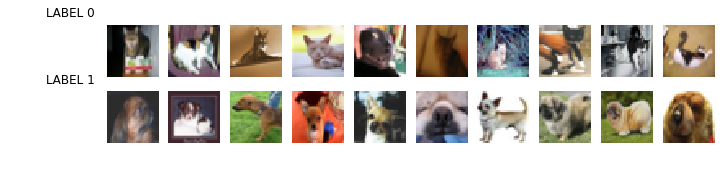

In [3]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()



(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
1    406
0    394
dtype: int64

distribution of test classes
0    109
1     91
dtype: int64


## Part 1: train a model with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [5]:
def get_model(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [6]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [7]:
num_classes = len(np.unique(y_cifar))
model1 = get_model(num_classes)
model1.summary()

using 2 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense

In [8]:
train(model1, batch_size=20, epochs=50)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.7027 - acc: 0.4688 - val_loss: 0.6931 - val_acc: 0.4550
Epoch 2/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6936 - acc: 0.4888 - val_loss: 0.6935 - val_acc: 0.4550
Epoch 3/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6934 - acc: 0.4925 - val_loss: 0.6932 - val_acc: 0.4550
Epoch 4/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6934 - acc: 0.4963 - val_loss: 0.6932 - val_acc: 0.4300
Epoch 5/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6931 - acc: 0.5387 - val_loss: 0.6934 - val_acc: 0.4500
Epoch 6/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6938 - val_acc: 0.4550
Epoch 7/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6934 - acc: 0.4913 - val_loss: 0.6942 - val_acc: 0.4550
Epoch 8/50
800/8

{'acc': 0.54, 'loss': 2.7122978019714354}

Normalized confusion matrix
[[0.58715596 0.41284404]
 [0.51648352 0.48351648]]


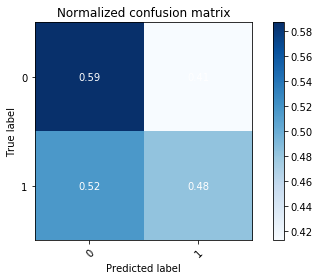

In [9]:
test_preds = model1.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

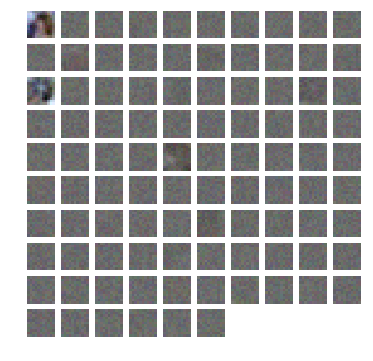

In [10]:
mlutils.display_imgs(model1.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [11]:
from tensorflow.keras.models import load_model
model2 = load_model("alexnet_finetuned_minicifar.model",custom_objects=None, compile=True)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
__________

In [12]:
w1 = model1.get_weights()
w2 = model2.get_weights()

In [13]:
w1[0] = model2.get_weights()[0] 
w1[1] = model2.get_weights()[1] 
w1[2] = model2.get_weights()[2] 
w1[3] = model2.get_weights()[3] 

In [14]:
print w1[3].shape

(60,)


In [15]:
print " -- model 1 weights --"
for i in w1:
    print i.shape # print all weights shapes of model 1

 -- model 1 weights --
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 64)
(64,)
(64, 64)
(64,)
(64, 2)
(2,)


In [16]:
print " -- model 2 weights --"
for i in w2:
    print i.shape # print all weights shapes of model 2

 -- model 2 weights --
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


 ## new model with the same architecture of Part 1

In [17]:
model3 = get_model(num_classes)
model3.summary()

using 2 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3904      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160 

### transfer weights!!

### you should transfer weights and biases of only the convolutional layers

`w1` must contain the transferred weights from `w2`

In [18]:
model3.set_weights(w1)

### train!!!

In [19]:
train(model3, batch_size=20, epochs=50)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 1ms/sample - loss: 3.0638 - acc: 0.5175 - val_loss: 0.8650 - val_acc: 0.4800
Epoch 2/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.7789 - acc: 0.5263 - val_loss: 0.7290 - val_acc: 0.4650
Epoch 3/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6764 - acc: 0.5250 - val_loss: 0.7304 - val_acc: 0.4700
Epoch 4/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6575 - acc: 0.5512 - val_loss: 0.6942 - val_acc: 0.5450
Epoch 5/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6513 - acc: 0.5375 - val_loss: 0.7002 - val_acc: 0.5150
Epoch 6/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.6173 - acc: 0.5838 - val_loss: 0.7072 - val_acc: 0.5250
Epoch 7/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.5889 - acc: 0.6012 - val_loss: 0.7929 - val_acc: 0.5650
Epoch 8/50
800/8

{'acc': 0.585, 'loss': 3.5778526878356933}

Normalized confusion matrix
[[0.56880734 0.43119266]
 [0.3956044  0.6043956 ]]


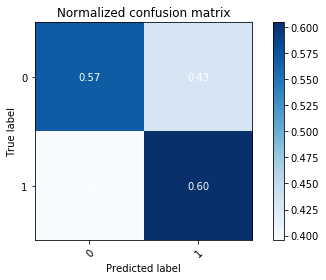

In [20]:
test_preds = model3.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

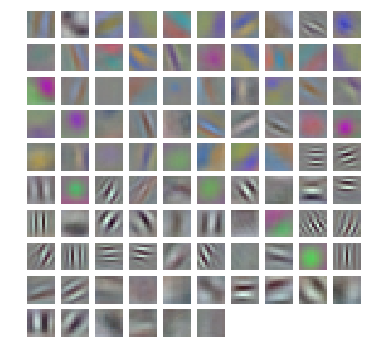

In [21]:
mlutils.display_imgs(model3.get_weights()[0])

## Modelo 1: Como se pide en el taller y entrenamiento con pesos aleatorios


## Modelo 2: Como se pide en el taller y entrenamiento con inicialización de pesos de acuerdo a las transferencia de aprendizaje

Text(0,0.5,'accuracy in train')

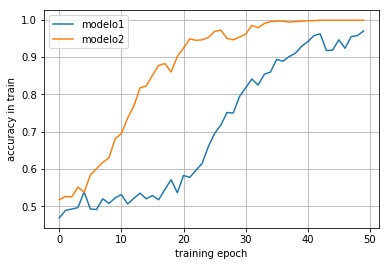

In [22]:
plt.plot(model1.history.history["acc"], label="modelo1");
plt.plot(model3.history.history["acc"], label="modelo2");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")


#### De la gráfica se puede observar que al hacer tranferencia de aprendizaje, es decir, ajustar los pesos de las capas del nuevo modelo que son similares al modelo cargado en las notas de clase, se tiene una mejor exactitud en el entrenamiento del modelo. Esto se debe a que son filtros que se han generado de entrenamientos de redes más complejas y cuyo costo computacional es alto; aprovechar los pesos de modelos como éste mejora la exactitud de una nueva arquitectura como en nuestro caso.

Text(0,0.5,'Loss function')

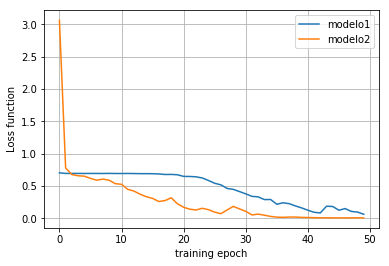

In [23]:
plt.plot(model1.history.history["loss"], label="modelo1");
plt.plot(model3.history.history["loss"], label="modelo2");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("Loss function")


#### De la gráfica se puede observar que el modelo con transferencia de aprendizaje tiene una optimización más rápida que el que no tiene, además de llegar a un valor mínimo más bajo que el modelo que realiza el entrenamiento con inicialización de pesos aleatorios. 